In [148]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

In [149]:
# Load dataset
file_path = r'creditcard.csv' 
df = pd.read_csv(file_path)

print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [150]:
# Any missing data?
for i in df.columns:
    percent_missing = np.mean(df[i].isnull())
    print('{} - {}%'.format(i, percent_missing))

Time - 0.0%
V1 - 0.0%
V2 - 0.0%
V3 - 0.0%
V4 - 0.0%
V5 - 0.0%
V6 - 0.0%
V7 - 0.0%
V8 - 0.0%
V9 - 0.0%
V10 - 0.0%
V11 - 0.0%
V12 - 0.0%
V13 - 0.0%
V14 - 0.0%
V15 - 0.0%
V16 - 0.0%
V17 - 0.0%
V18 - 0.0%
V19 - 0.0%
V20 - 0.0%
V21 - 0.0%
V22 - 0.0%
V23 - 0.0%
V24 - 0.0%
V25 - 0.0%
V26 - 0.0%
V27 - 0.0%
V28 - 0.0%
Amount - 0.0%
Class - 0.0%


Non-Fraudulant transactions: 99.83 % of the dataset
Fraudulant transactions: 0.17 % of the dataset


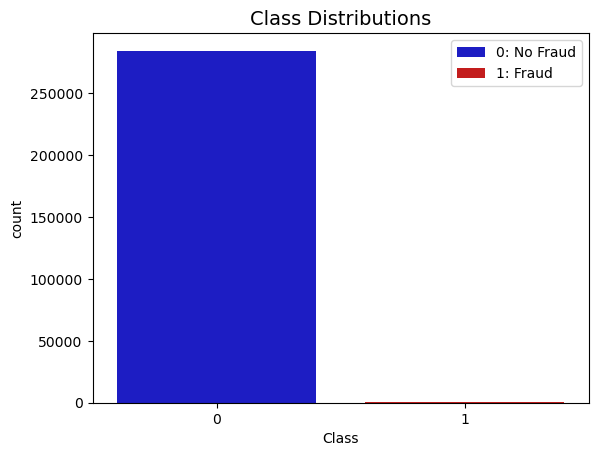

In [151]:
# Check class distribution, data is highly imbalanced (492 frauds out of 284,807 transactions)
print('Non-Fraudulant transactions:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Fraudulant transactions:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

# Export class distribution data as an excel file for Tableau visualization
non_fraud_count =  df['Class'].value_counts()[0]
fraud_count =  df['Class'].value_counts()[1]

summary_df_original = pd.DataFrame({
    'Transaction Type': ['Non-Fraudulent', 'Fraudulent'],
    'Count': [non_fraud_count, fraud_count],
    'Stage': 'Original'
})

# Show count plot
colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Class', data=df, hue='Class', palette=colors, legend=True)
plt.title('Class Distributions', fontsize=14)
plt.legend(labels=['0: No Fraud', '1: Fraud'], loc='upper right')
plt.show()

In [152]:
# Most data is already scaled with PCA, need to scale columns Amount and Time as add as new columns
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


In [153]:
# Balance data with UNDERSAMPLING
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

new_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle rows
undersampled_df = new_df.sample(frac=1, random_state=33)

undersampled_df.head()

non_fraud_count =  undersampled_df['Class'].value_counts()[0]
fraud_count =  undersampled_df['Class'].value_counts()[1]

summary_df_under = pd.DataFrame({
    'Transaction Type': ['Non-Fraudulent', 'Fraudulent'],
    'Count': [non_fraud_count, fraud_count],
    'Stage': 'Undersampling'
})

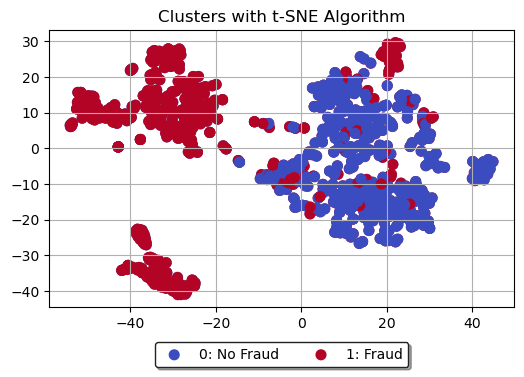

In [154]:
# Use t-SNE algorithm with undersampled data, can data be accurately clustered?
# Clustered data is a good sign that predictive models can be used to accurately separate fraud from non-fraud cases
x = undersampled_df.drop('Class', axis=1)
y = undersampled_df['Class']

# t-SNE implementation
X_reduced_tsne = TSNE(n_components=2, random_state=33).fit_transform(x.values)

clustering_data = pd.DataFrame(
    data={
        "Dimension 1": X_reduced_tsne[:, 0],
        "Dimension 2": X_reduced_tsne[:, 1],
        "Label": y,
    }
)
clustering_data.to_excel("clustering.xlsx")

# t-SNE scatter plot
plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

plt.title("Clusters with t-SNE Algorithm")

plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', linewidths=2)

plt.grid(True)

# Shrink axis's height by 10% on the bottom and add legend
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(labels=['0: No Fraud', '1: Fraud'], loc='upper center', bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=5).get_frame().set_edgecolor('#202121')

plt.show()

In [155]:
# Define training and testing sets for original dataframe
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=33)

In [156]:
# Define training and testing sets for undersampled dataframe
X_under= df.drop('Class', axis=1)
y_under = df['Class']
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size = 0.3, random_state = 33)

In [157]:
# Model training and evaulation
param_grid_knn = {
    'n_neighbors': [5, 7],                                   
    'algorithm': ['auto'],          
    'metric': ['minkowski', 'euclidean']
}

kNNModel_grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, verbose=1, cv=3, n_jobs=-1)
kNNModel_grid.fit(X_train_under, y_train_under)
print(kNNModel_grid.best_estimator_)
 
# Test model on original dataframe
y_pred = kNNModel_grid.predict(X_test)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
KNeighborsClassifier()


In [158]:
# Print and export classification report as excel
print("Classification Report:")
report1 = classification_report(y_test, y_pred, output_dict=True)
report1_df = pd.DataFrame(report1)
report1_df["Stage"] = "Under"
report1_df.to_excel("classification_report_stage1.xlsx", index=True)
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.81      0.87       148

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



Recall metric in the testing dataset:  0.8108108108108109


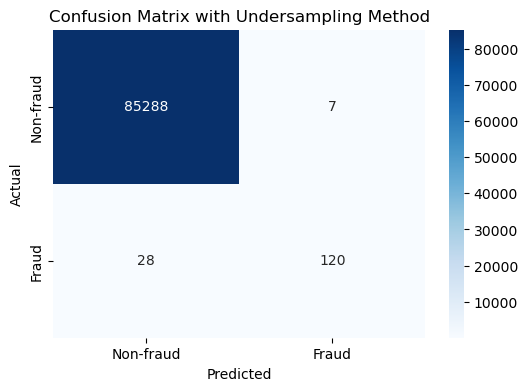

In [159]:
# Compute confusion matrix using undersampling to balance data
cm_1 = confusion_matrix(y_test, y_pred)

cm_1_df = pd.DataFrame(cm_1)
cm_1_df.to_excel("cm_1.xlsx")

print("Recall metric in the testing dataset: ", cm_1[1,1]/(cm_1[1,0]+cm_1[1,1]))

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_1, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-fraud", "Fraud"], yticklabels=["Non-fraud", "Fraud"])
plt.title("Confusion Matrix with Undersampling Method")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Balanced Training Set Distribution: Counter({0: 199020, 1: 199020})


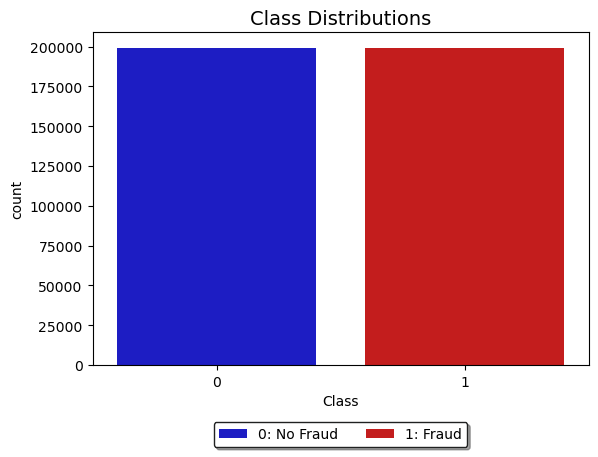

In [160]:
# SMOTE transformation
oversample = SMOTE(random_state=33)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)

# Summarize the new class distribution
counter = Counter(y_train_over)
print(f"Balanced Training Set Distribution: {counter}")

# Combine the resampled data into a DataFrame
smote_balanced_df = pd.DataFrame(X_train_over, columns=x.columns)  # Features
smote_balanced_df['Class'] = y_train_over  # Add the target column

# Show count plot
colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Class', data=smote_balanced_df, hue='Class', palette=colors, legend=True)
ax = plt.subplot(111)

non_fraud_count_smote =  smote_balanced_df['Class'].value_counts()[0]
fraud_count_smote =  smote_balanced_df['Class'].value_counts()[1]

summary_df_smote = pd.DataFrame({
    'Transaction Type': ['Non-Fraudulent', 'Fraudulent'],
    'Count': [non_fraud_count_smote, fraud_count_smote],
    'Stage': 'Balancing with SMOTE'
})

plt.title('Class Distributions', fontsize=14)

# Shrink axis's height by 10% on the bottom and add legend
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(labels=['0: No Fraud', '1: Fraud'], loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=5).get_frame().set_edgecolor('#202121')

plt.show()

In [161]:
# Model training and evaulation
kNNModel_grid_smote = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, verbose=1, cv=3, n_jobs=-1)
kNNModel_grid_smote.fit(X_train_under, y_train_under)
 
# Make predictions
y_pred_smote = kNNModel_grid_smote.predict(X_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [162]:
# Print and export classification report
print("Classification Report:")
report2 = classification_report(y_test, y_pred_smote, output_dict=True)
report2_df = pd.DataFrame(report2)
report2_df["Stage"] = "Smote"
report2_df.to_excel("classification_report_stage2.xlsx", index=True)
print(classification_report(y_test, y_pred_smote))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.94      0.81      0.87       148

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



Recall metric in the testing dataset:  0.8108108108108109


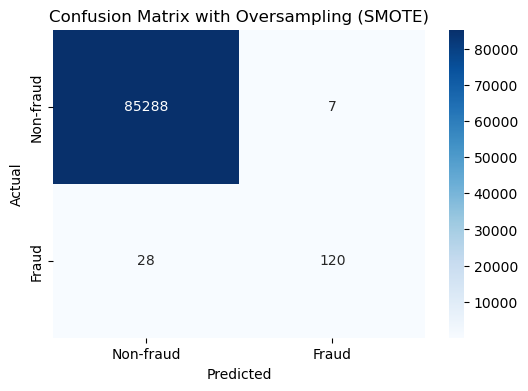

In [163]:
# Compute confusion matrix using oversampling to balance data
cm_2 = confusion_matrix(y_test, y_pred_smote)

cm_2_df = pd.DataFrame(cm_2)
cm_2_df.to_excel("cm_2.xlsx")

print("Recall metric in the testing dataset: ", cm_2[1,1]/(cm_2[1,0]+cm_2[1,1]))

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_2, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-fraud", "Fraud"], yticklabels=["Non-fraud", "Fraud"])
plt.title("Confusion Matrix with Oversampling (SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

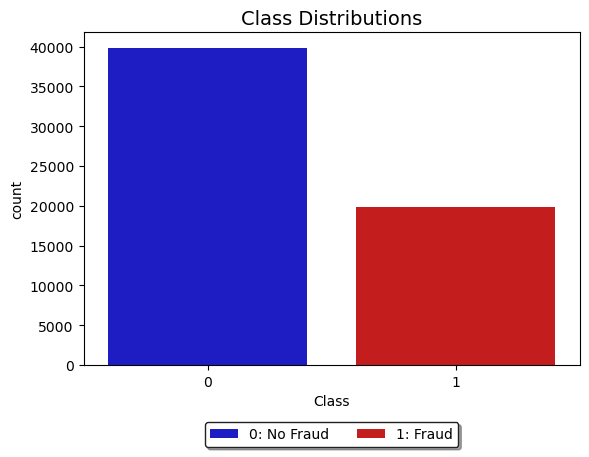

In [164]:
# Original paper on SMOTE suggests combining SMOTE with random undersamplling
# Defining pipeline:
# First oversample minority class to have 10% of the number of examples from majority class
# Then undersample majority class to reduce number of examples to 50% more than minority class
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Transform data with pipeline
X_train_combined, y_train_combined = pipeline.fit_resample(X_train, y_train)

# Combine the resampled data into a DataFrame
X_combined = df.drop('Class', axis=1)
combined_balanced_data = pd.DataFrame(X_train_combined, columns=X.columns)
combined_balanced_data['Class'] = y_train_combined

non_fraud_count_combined =  combined_balanced_data['Class'].value_counts()[0]
fraud_count_combined =  combined_balanced_data['Class'].value_counts()[1]

summary_df_combined = pd.DataFrame({
    'Transaction Type': ['Non-Fraudulent', 'Fraudulent'],
    'Count': [non_fraud_count_combined, fraud_count_combined],
    'Stage': 'Balancing with Undersampling and SMOTE'
})

# Visualize new class distribution for more balanced data after oversampling (SMOTE) and undersampling
colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Class', data=combined_balanced_data, hue='Class', palette=colors, legend=True)
ax = plt.subplot(111)

plt.title('Class Distributions', fontsize=14)

# Shrink axis's height by 10% on the bottom and add legend
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(labels=['0: No Fraud', '1: Fraud'], loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=5).get_frame().set_edgecolor('#202121')

plt.show()

In [165]:
# Model training and evaulation
kNNModel_grid_smote = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn, verbose=1, cv=3, n_jobs=-1)
kNNModel_grid_smote.fit(X_train_combined, y_train_combined)
print(kNNModel_grid_smote.best_estimator_)
 
# Make predictions
y_pred_combined = kNNModel_grid_smote.predict(X_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
KNeighborsClassifier()


In [166]:
# Print and export classification report
print("Classification Report:")
report3 = classification_report(y_test, y_pred_combined, output_dict=True)
report3_df = pd.DataFrame(report3)
report3_df["Stage"] = "Combination"
report3_df.to_excel("classification_report_stage3.xlsx", index=True)
print(classification_report(y_test, y_pred_combined))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.17      0.91      0.29       148

    accuracy                           0.99     85443
   macro avg       0.58      0.95      0.64     85443
weighted avg       1.00      0.99      0.99     85443



Recall metric in the testing dataset:  0.9054054054054054


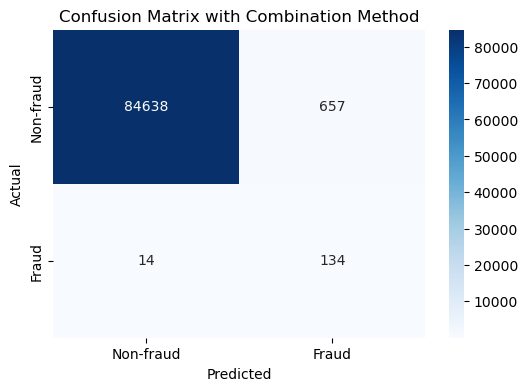

In [167]:
# Compute confusion matrix
cm_3 = confusion_matrix(y_test, y_pred_combined)

cm_3_df = pd.DataFrame(cm_3)
cm_3_df.to_excel("cm_3.xlsx")

print("Recall metric in the testing dataset: ", cm_3[1,1]/(cm_3[1,0]+cm_3[1,1]))

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_3, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-fraud", "Fraud"], yticklabels=["Non-fraud", "Fraud"])
plt.title("Confusion Matrix with Combination Method")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [168]:
results_df = pd.concat([summary_df_original, summary_df_under, summary_df_smote, summary_df_combined])
results_df.to_excel("class_distrib.xlsx") 
results2_df = pd.concat([report1_df, report2_df, report3_df])
results2_df.to_excel("class_report.xlsx")